### Exploring Cape Python with PySpark: Taxi Dataset

This Jupyter Notebook was presented as part of [Coiled's Science Thursdays](https://coiled.io/blog/data-privacy-distributed-compute.html). To follow along, you will need to [download the example dataset](https://data.cityofnewyork.us/dataset/2016-Yellow-Taxi-Trip-Data/uacg-pexx) and put it in a relative folder called `data` (or update the file path below). You will also need to [download the policy file]() and put it in a relative folder called `policy` or ensure you have Cape Python installed locally and change the path to use the copy in the `examples` folder.

For more information on Cape Python, please check out our [documentation](https://docs.capeprivacy.com/libraries/cape-python/).

In [19]:
spark

In [20]:
import cape_privacy as cape
from pyspark.sql.types import IntegerType

## What do we know about this dataset?

[Dataset Documentation](https://data.cityofnewyork.us/dataset/2016-Yellow-Taxi-Trip-Data/uacg-pexx): You can also download the dataset on this page. Please note it is about 7G of data.

[Data Column Description](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf): This can tell us more information about the columns available.

[Latitude and Longitude](https://en.wikipedia.org/wiki/Decimal_degrees): A nice resource for analyzing the precision of different decimal points of Latitude and Longitude degrees

In [21]:
cape.spark.transformations.NumericRounding?

In [22]:
df = spark.read.csv('../data/2016_Yellow_Taxi_Trip_Data.csv',header=True)

In [23]:
df.sample(0.1).limit(3).show()

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|PULocationID|DOLocationID|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+------------+
|       2|01/02/2016 08:05:...| 01/02/2016 08:26:...

In [24]:
!cat ../policy/nyc_taxi_dataset_policy.yaml

label: taxi_dataset_policy
version: 1
rules:
  - match:
      name: VendorID 
    actions:
      - transform:
          type: "tokenizer"
          max_token_len: 10
          key: "Please change this :)"
  - match:
      name: passenger_count
    actions:
      - transform:
          type: "numeric-perturbation"
          dtype: Integer
          min: 0
          max: 2
  - match:
      name: pickup_longitude
    actions:
      - transform:
          type: "numeric-rounding"
          dtype: Double
          precision: 4
  - match:
      name: pickup_latitude
    actions:
      - transform:
          type: "numeric-rounding"
          dtype: Double                   
          precision: 4                   
  - match:
      name: dropoff_longitude                    
    actions:                                    
      - transform:                              
          type: "numeric-rounding"              
          dtype: Double                         
          precision: 4  

In [25]:
policy = cape.parse_policy("../policy/nyc_taxi_dataset_policy.yaml")
caped_df = cape.apply_policy(policy, df)

/usr/local/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [26]:
caped_df.sample(0.1).limit(3).show()

+----------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|  VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RatecodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+----------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|5cf1d034a9|01/10/2016 01:07:...| 01/10/2016 01:35:...|            6.0|         5.88|        -73.9813|        40.7809|         1|                 N|      

In [27]:
caped_histogram = caped_df.select("passenger_count").rdd.flatMap(lambda x: x).histogram(10)

In [28]:
raw_histogram = df.select(df.passenger_count.cast("integer").alias('passenger_count_int')).rdd.flatMap(lambda x: x).histogram(10)

In [29]:
%matplotlib inline
import pandas as pd

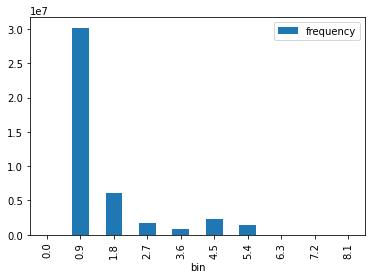

In [30]:
pd.DataFrame(
    list(zip(*raw_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

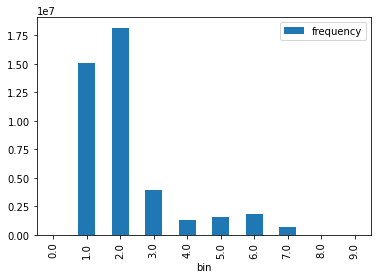

In [31]:
pd.DataFrame(
    list(zip(*caped_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');